## Import Necessary Dependencies

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
%matplotlib notebook

## Import Data

In [208]:
def convert_nan(string):
    try:
        i = float(string)
        return i 
    except ValueError:
        #Handle the exception
        return np.NaN
       
data = pd.read_csv('Assignment-2_gene_data.csv',converters={'S2':convert_nan,'S13':convert_nan})
meta_data = pd.read_csv('Assignment-2 Meta data sheet .csv')
data = data.dropna()
data = data.drop('Unnamed: 0',axis=1)
data = data.drop_duplicates()
data = data.set_index('symbol')

### Plot Corelation Between various samples

<IPython.core.display.Javascript object>


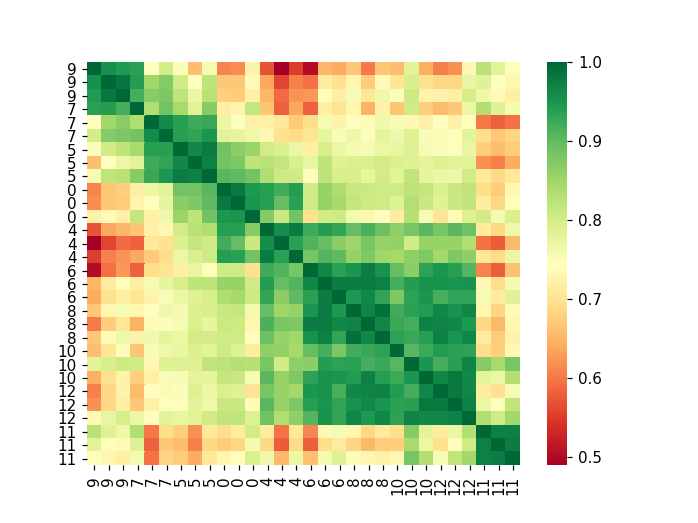

In [209]:
data_corr = data.corr()
plt.figure()
sns.heatmap(data_corr,cmap='RdYlGn',yticklabels=meta_data.Time,xticklabels=meta_data.Time)
plt.show()

## Sort Columns by time and make scatter plot for easy interpreatation

<IPython.core.display.Javascript object>


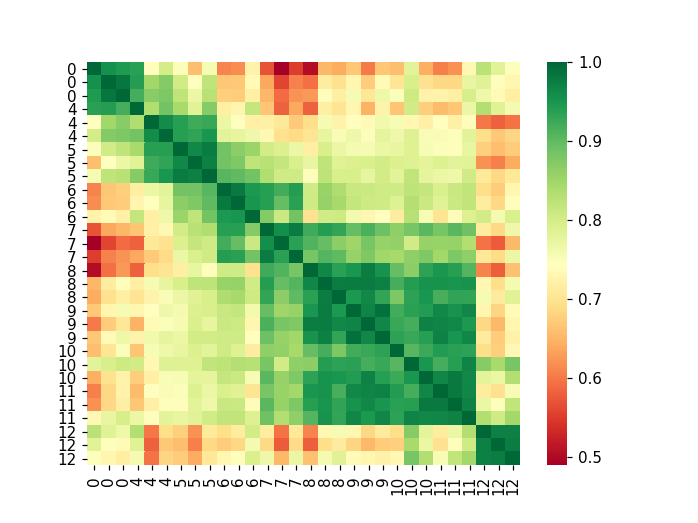

In [210]:
meta_data = meta_data.sort_values(by="Time")
data = data[meta_data.sIdx]
plt.figure()
sns.heatmap(data_corr,cmap='RdYlGn',yticklabels=meta_data.Time,xticklabels=meta_data.Time)
plt.show()

## Based on this scatter plot we bin the time for every 2 hours

In [211]:
bins = [-0.1,2,4,6,8,10,12.1]
labels = ['0-2 hrs','2-4 hrs','4-6 hrs','6-8 hrs','8-10 hrs','10-12 hrs']
meta_data['time_binned'] = pd.cut(meta_data['Time'],bins=bins,labels = labels,right=False)

## Ideally, To have more clean principal components we should remove highly corelated variables
### But we do not remove these variables right now 

### import PCA libraries

In [212]:
from sklearn.decomposition import PCA

### Scale the data to perform PCA

In [213]:
from sklearn.preprocessing import StandardScaler
data_std = StandardScaler().fit_transform(data)

In [214]:
sklearn_pca = PCA()
data_pca = pd.DataFrame(sklearn_pca.fit_transform(data_std))

### lets plot the transformed data
### Here we can see that PC1 explains 80.98 % variance in the data, and the other prinicpal components contribute very less. This could be due to the fact that a lot of correlated columns contribute to PC1 which increases the variance explained by PC1

<IPython.core.display.Javascript object>


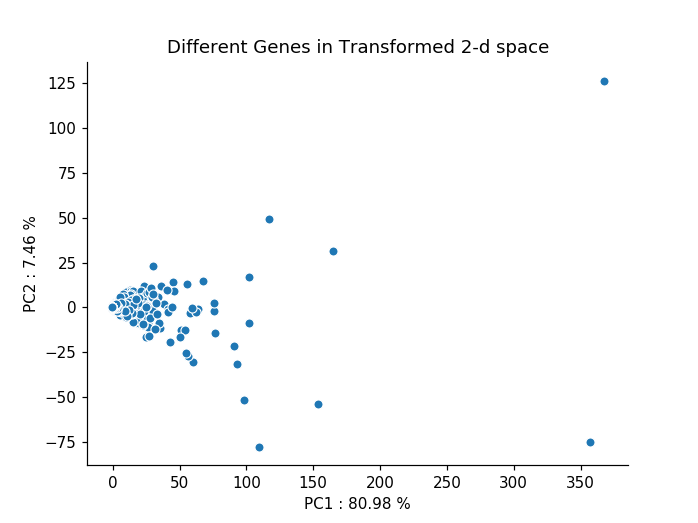

In [241]:
plt.figure()
fig = sns.scatterplot(data_pca[0],data_pca[1])
fig.set_xlabel("PC1 : {0:.2f} %".format(sklearn_pca.explained_variance_ratio_[0]*100))
fig.set_ylabel("PC2 : {0:.2f} %".format(sklearn_pca.explained_variance_ratio_[1]*100))
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
fig.set_title('Different Genes in Transformed 2-d space')
plt.show()

### Now lets plot the contribution of each sample to PC1 and PC2

In [216]:
## Create a color array
color_dict = {}
for t_bin,color in zip(meta_data.time_binned.unique(),['b','g','r','c','m','y']):
    color_dict[t_bin] = color

cmap = []
for b in meta_data.time_binned:
    cmap.append(color_dict[b])

legends = []
for key in color_dict:
     legends.append(mpatches.Patch(color=color_dict[key], label=key))


In [217]:
## Just to have an idea of which bins have more values
meta_data.time_binned.value_counts()

10-12 hrs    9
8-10 hrs     6
6-8 hrs      6
4-6 hrs      6
0-2 hrs      3
2-4 hrs      0
Name: time_binned, dtype: int64

<IPython.core.display.Javascript object>


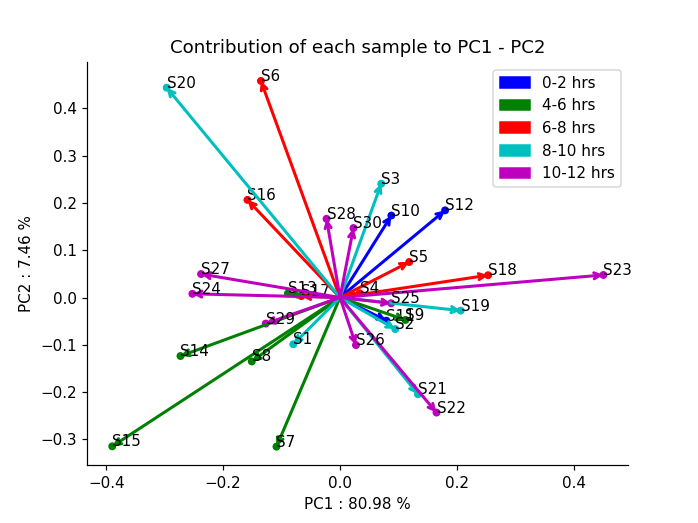

In [242]:

data_eigen_vector = pd.DataFrame(sklearn_pca.components_)
plt.figure()
ax = sns.scatterplot(data_eigen_vector[0],data_eigen_vector[1],color=cmap)
ax.legend(handles=legends)
ax.set_xlabel("PC1 : {0:.2f} %".format(sklearn_pca.explained_variance_ratio_[0]*100))
ax.set_ylabel("PC2 : {0:.2f} %".format(sklearn_pca.explained_variance_ratio_[1]*100))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Contribution of each sample to PC1 - PC2')
for row,color,sample in zip(data_eigen_vector.iterrows(),cmap,meta_data.sIdx):
    arrowprops=dict(
        color = color,
        arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, 
                    shrinkB=0
                    
                   )
    ax.annotate('', (row[1][0],row[1][1]), (0,0), arrowprops=arrowprops)
    ax.annotate(sample, (row[1][0],row[1][1]), (row[1][0],row[1][1]),)
    
plt.show()

## The results are as expected
### The columns which fall within the group `10-12 hrs` and `4-6 hrs` are highly corelated, have high value_counts() and thus PC1 is dominated by this bracket. This justifies the fact that PC1 accounts for `80.98 %` of variation, and the immediate next PC2 accounts only for `7.46 %`

### Also we can see that contribution by sample of `0-2 hrs` and `4-6 hrs` lie far apart in the graph. Thus we can safely conclude that time plays a major role when taking gene samples.
### Therefore samples taken at distant point in time are likely to have different values for the gene.